In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
import warnings
from umap import UMAP
from typing import List, Union, Optional
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [182]:
emoji_vectors = pd.read_pickle("emoji_vectors_data.pkl").set_index("tweet_id")
topic_scores = pd.read_pickle("topic_scores_df.pkl")
emotion_scores = pd.read_csv("tweet_emotions.csv", index_col=[0])
sentiment_scores = pd.read_csv("sentiments.csv", index_col=[0])
tweets = pd.read_csv("tweets_data.csv", parse_dates=["created_at"]).dropna(subset=["tweet_id"]).set_index("tweet_id")

In [184]:
# sentiment_scores.head()

All the emoji ids and the emojis

In [6]:
for eid in emoji_vectors.emoji_id.unique():
    print(eid, emoji.EMOJI_UNICODE_ENGLISH[tokenizer.convert_ids_to_tokens([eid])[0]])

871 ☺️
1585 ♀️
2555 ♂️
1672 ✌️
1658 ✨
280 ❤️
1696 🎉
1315 🏻
1277 🏽
1715 👀
820 👌
1055 👍
1320 👏
1651 💀
3183 💋
2507 💔
663 💕
1548 💖
1919 💗
3026 💘
1759 💙
3581 💚
2968 💛
1376 💜
2749 💞
1088 💯
1382 🔥
838 😁
88 😂
1411 😅
1322 😉
518 😊
390 😍
1022 😏
908 😔
722 😘
491 😩
247 😭
1107 😳
1138 🙄
1663 🙈
1152 🙌
933 🙏
1422 🤣
2541 🤦
2144 🤷
6239 🥺


This class is an essentially one-stop shop that hosts all the data and functions used in the clustering prayer hands notebook.

In [334]:
e = {"3":3}

In [335]:
e.get("4", "swag")

'swag'

In [3]:
def swag(model_params:Union[None, dict] = None, sample_frac:Union[None, float] = None):
    return model_params

In [357]:
class ClusterHub:    
    RANDOM_STATE = 1
    def __init__(self, emoji_id:int, model_class:Union[KMeans, AgglomerativeClustering],
                 model_params:Union[None, dict] = None, sample_frac:Union[None, float] = None):
        """
        
        Parameters:
        
        emoji_id: The numerical for the chosen emoji
        
        model_class: The type of model used for clustering, either KMeans or Agglormerative
        
        model_params: Defaults to None, but if it's dictionary then it's used parameters in an Agglomerative model.
        
        sample_frac: The proportion used for sampling if sampling is needed. None indicates no sampling used.
        
        Attributes:
        
        emoji_id: Sets the emoji id as an attribute
        
        emoji_token: The Bertweet tokenizer converts the emoji_id to a token
        
        emoji: Converts emoji token to emoji symbol
        
        emoji_df: Dataframe for the chosen emoji.
        
        sampled: If a float is used the sample_frac parameter, then this boolean will be changed to True and a new
        attribute called sampled_ids will be created.
        
        embeddings: Dataframe of embeddings for emoji.
        
        umap: Boolean to indicate whether or not umap embeddings have been produced.
        
        sil_metric: The metric used to evaluate silhouette scores. Defaults to euclidean but can be changed based on model_params.
        
        models: A dictionary used to store trained models. Keys = k-clusters, values = fit models.
        
        model_labels: A dictionary used to store cluster labels from trained models. Keys = k-clusters, values = model labels
        
        silhouette_scores: A dictionary used to silhouette scores. Keys = k-clusters, values = silhouette score.
        
        """
        self.emoji_id = emoji_id
        self.emoji_token = tokenizer.convert_ids_to_tokens([emoji_id])[0]
        self.emoji = emoji.EMOJI_UNICODE_ENGLISH[self.emoji_token]
        self.emoji_df = emoji_vectors.query("emoji_id == {}".format(emoji_id)).drop("emoji_id", axis = 1)
        self.sampled = False
        
        self.emoji_df = self.emoji_df.join(tweets)
        
        self.embeddings = self.emoji_df.embedding
        self.embeddings = self.embeddings.apply(pd.Series)
        self.umap = False
        
        if sample_frac:
            self.sampled = True
            self.sample_ids = self.embeddings.sample(frac = sample_frac, random_state=self.RANDOM_STATE).index.tolist()
            
        self.model_class = model_class
        self.model_params = model_params
        self.sil_metric = "euclidean"
        if model_params:
            self.sil_metric = model_params.get("metric", "euclidean")
        
        self.models = {}
        self.model_labels = {}
        self.silhouette_scores = {}
        
    def plot_tweet_rate(self, period:str= "M"):
        
        """
        Plots the rate of tweets for tweets containing chosen emoji.
        
        Parameters:
        
        period: Defaults to M (monthly)
        """
        
        tweet_rate = pd.Series(index=pd.to_datetime(self.emoji_df.created_at)).sort_index()
        tweet_rate.resample(period).size().plot(figsize = (9,6))
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.title(f"{period} Tweeting Rate of the {self.emoji_token} Emoji")
        
    def cluster_range(self, k_range:tuple=(2, 21)):
        """
        Fits a number of cluster models based on a chosen range values. Iterates over every integer between the two values in k_range tuple. 
        Trained models are saved to self.models, their labels are saved to self.model_labels, and
        silhouette scores are saved self.silhouette_scores.
        
        
        Parameters:
        
        k_range: Defaults to (2,21).
        """
        
        
        for k in tqdm(range(*k_range)):
            if self.model_params:
                model = self.model_class(n_clusters = k, **self.model_params)
            else:
                model = self.model_class(n_clusters = k, random_state = self.RANDOM_STATE)
            
            if self.sampled:
                sample = self.embeddings.loc[self.sample_ids]
                model.fit(sample)
                self.model_labels[k] = model.predict(self.embeddings)
                sil_score = silhouette_score(sample, model.labels_, metric= self.sil_metric)
            else:
                model.fit(self.embeddings)
                self.model_labels[k] = model.labels_
                sil_score = silhouette_score(self.embeddings, model.labels_, metric= self.sil_metric)

            self.models[k] = model
            self.silhouette_scores[k] = sil_score
            
    def labels_freq_prop(self, k:int):
        
        """
        Outputs a panda dataframe displaying the frequency and proportion of cluster labels for a chosen k value
        
        Parameters:
        
        k: Integer value for desired k clusters
        
        """
        
        labels = self.model_labels[k]
        freq = pd.value_counts(labels)
        prop = pd.value_counts(labels, normalize=True)
        return pd.concat([freq, prop], axis = 1).sort_index().rename(columns={0:"Frequency", 1:"Proportion"})
            
    def plot_silhouette_scores(self):
        
        """
        Plots a line plot displaying k-values versus their corresponding silhouette scores
        
        """
        if len(self.silhouette_scores) == 0:
            raise ValueError("You need calculate the silhouette scores first")
            
        xvals = list(self.silhouette_scores.keys())
        yvals = list(self.silhouette_scores.values())
        plt.plot(xvals, yvals)
        plt.xlabel("K Values")
        plt.ylabel("Silhouette Scores")
        plt.xticks(ticks = xvals);
        
    def produce_umap(self):
        
        """
        Produces umap embeddings for visualizing in a 2D scatter plot and saves them as an attribute (umap_mat)
        """
        
        if self.umap:
#             print("Umap embeddings already created")
            return None
        
        umap = UMAP(random_state=self.RANDOM_STATE, n_neighbors = 30, metric = "cosine")
        
        if self.sampled:
            sample = self.embeddings.loc[self.sample_ids]
            umap.fit(sample)
            self.umap_mat = umap.transform(self.embeddings)
        else:
            self.umap_mat = umap.fit_transform(self.embeddings)
            
        self.umap = True
            
            
    def plot_umap(self, k = None):
        """
        Plots the umap embeddings in a 2d space. Runs the self.produce_umap method in order to produce the umap matrix.
        
        
        Parameters:
        
        k: The number of clusters used to color-encode the dots on the scatter plot. If None, no color-encoding is used.
        """
        
        self.produce_umap()
        

        X = self.umap_mat[:, 0]
        y = self.umap_mat[:, 1]
        labels = None
        if k:
            labels = self.model_labels[k]
        
        plt.figure(figsize = (11, 9))        
#         plt.scatter(X, y, c = labels, alpha = .4)
        sb.scatterplot(x = X, y = y, hue=labels, alpha = .4, palette = "deep")
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.show()
         
    
    def return_k_clusters_df(self, k):
        
        """
        A helper function used to create a dataframe where columns represent cluster labels, rows represent tweet ids, 
        and values are the frequency of a cluster label in a tweet.
        
        
        Parameters:
        
        k: Desired number of k clusters.
        """
        
        labels_df = self.emoji_df.assign(labels = self.model_labels[k]).labels
        return labels_df.reset_index().pivot_table(index = "tweet_id", columns="labels", aggfunc=len, fill_value=0)


        
    def topic_scores(self, k):
        
        """
        Produces a table of the mean topic scores grouped by cluster label. The topic scores dataframe contains scores 
        derived by a huggingface topic model that outputs topic scores for 19 chosen topics. The output is a
        19xk dimension dataframe.
        
        Parameters:
        
        k: Desired number of k clusters.
        """
        
        labels_df = self.return_k_clusters_df(k)
        
        label_means = []

        for i in labels_df.columns:
            mean_topic_cluster = topic_scores.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
            label_means.append(mean_topic_cluster)

        label_means = pd.concat(label_means, axis = 1)
        if k>2:
            label_means["standard_dev"] = label_means.std(axis = 1)
            label_means.sort_values("standard_dev", ascending = True, inplace=True)
        else:
            label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
            label_means.sort_values("absolute_difference", ascending=True, inplace=True)
        
        return label_means
    
    def emotion_sentiment_scores(self, k):
        
        """
        Produces a table of the mean emotion and sentiment scores grouped by cluster label. 
        The emotion and sentiment scores dataframe contains scores derived by huggingface-hosted models
        that outputs topic scores for 5 emotions and 3 sentiments. The output is a
        8xk dimension dataframe.
        
        Parameters:
        
        k: Desired number of k clusters.
        
        """
        
        labels_df = self.return_k_clusters_df(k)

        label_emotion_means = []
        label_sentiment_means = []

        for i in labels_df.columns:
            mean_emotion_cluster = emotion_scores.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
            label_emotion_means.append(mean_emotion_cluster)

        for i in labels_df.columns:
            mean_sentiment_cluster = sentiment_scores.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
            label_sentiment_means.append(mean_sentiment_cluster)

        label_emotion_means = pd.concat(label_emotion_means, axis = 1)
        label_emotion_means.index = "Emotion_" + label_emotion_means.index
        label_sentiment_means = pd.concat(label_sentiment_means, axis = 1)
        label_sentiment_means.index = "Sentiment_" + label_sentiment_means.index

        label_means = pd.concat([label_emotion_means, label_sentiment_means])

        if k > 2:
            label_means["standard_dev"] = label_means.std(axis = 1)
            label_means.sort_values("standard_dev", ascending = True, inplace=True)
        else:
            label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
            label_means.sort_values("absolute_difference", ascending=True, inplace=True)

        return label_means
    
    
    
    def plot_clf_scores(self, k, topics = True):
        """
        
        Function used to plot dot plot of either the mean topic or emotion/sentiment scores. 
        Dots are sorted by greatest difference between scores (for k = 2) or standard deviation of scores (for k>2)
        
        
        Parameters:
        
        k = Desired number of clusters
        
        topics: True means plot topic scores, False mean plot emotion/sentiment scores.
        """
        
        if topics:
            label_means = self.topic_scores(k)
        else:
            label_means = self.emotion_sentiment_scores(k)
        
        plt.figure(figsize=(14, 10))

        y_ticks = label_means.index.str.replace("_", " ").str.title().tolist()
        
        for i in label_means.columns[:-1]:
            values = label_means[i].values
            plt.plot(values, y_ticks, "o", label = i.replace("_", " ").title())

        plt.legend(loc = 5, fontsize = 15)
        plt.show()
        
        
    def show_centroid_tweets(self, k, n = 10):
        
        """
        Print out the n most representative tweets for each cluster label. Uses euclidean distance to derive
        the n closests tweets to each cluster label's centroid.
        
        Parameters:
        
        k = Desired number of clusters
        
        
        n = Number of closest tweets
        
        """
        
        dists = euclidean_distances(self.models[k].cluster_centers_, self.embeddings)
        dists_argsort = dists.argsort(axis = 1)
        
        centriod_tweets = {}
        for i in range(len(dists_argsort)):
            row = dists_argsort[i]
            top_n_args = row[:n]
            tweet_ids = self.embeddings.index[top_n_args]
            centriod_tweets["cluster_{}".format(i)] = list(set(((self.emoji_df.loc[tweet_ids].text.tolist()))))
            
        for k, v in centriod_tweets.items():
            print(k.title()+":\n")
            for i in v:
                print("|",i, "|")
            print("\n")
        
        
            
    def words_ratio(self, k, max_df = .5, min_df = 0.005):
        
        """
        Produces the most representative words from tweets containing a given cluster label.
        
        1. Creates a dataframe of labels using self.return_k_clusters_df
        
        2. Creates a document term matrix using parameters max_df and min_df.
        
        3. Iterates over clusters labels. 
            a. Grabs ids of tweets contain given cluster label and creates a subset of the dtm
            b. Sums up the word frequencies and normalizes them
            c. Repeats process for tweets not pertaining to the label.
            d. Derives ratio between normalized word frequencies for the in and out of label dtms.
            e. Saves ratio to dictionary
            
        4. Creates a dataframe of the 10 words with the largest ratioes.
        
        
        Parameters:
        
        
        k: Desired number of cluster labels.
        
        max_df: Used to configure the CountVectorizer object. The maximum number or proportion of documents a word could
        appear in in order to create the document term matrix
        
        min_df: Used to configure the CountVectorizer object. The minimum number or proportion of documents a word could
        appear in in order to create the document term matrix
        
        
        """
        
        labels_df = self.return_k_clusters_df(k)
        emoji_text = self.emoji_df.reset_index().groupby("tweet_id").text.unique().apply(lambda x:x[0])
        countvec = CountVectorizer(max_df=max_df, min_df=min_df,
                                   preprocessor=tokenizer.normalizeTweet, 
                                   stop_words="english")
        
        dtm = countvec.fit_transform(emoji_text).toarray()
        features = countvec.get_feature_names_out()
        dtm = pd.DataFrame(index=emoji_text.index, data = dtm, columns = features)
        
        ratio_dict = {}
        
      
        for i in labels_df.columns:
            label_ids = labels_df[labels_df.loc[:, i] == 1].index

            word_counts_label = dtm.loc[label_ids].sum()
            word_counts_label_norm = word_counts_label/word_counts_label.sum()

            word_counts_out_of_label = dtm.drop(label_ids).sum().replace(0, 1)
            word_counts_out_of_label_norm = word_counts_out_of_label/word_counts_out_of_label.sum()
            ratio = word_counts_label_norm/word_counts_out_of_label_norm
            ratio_dict["cluster_{}".format(i)] = ratio
        
        ratio_table = []
        for k, v in ratio_dict.items():
            name = k.title().replace("_", " ")
            v = v.nlargest(10).reset_index().rename(columns = {"index": name +" Words" ,
                                                               0: name + " Scores"})
            ratio_table.append(v)
        return pd.concat(ratio_table, axis = 1 )
    
    def visualize_clusters_over_time(self, k, period = "M"):
        """
        Produces three subplots charting the rate of tweet containing cluster labels.
        
        Left plot shows the rate of tweeting for each label.
        
        Center plot shows a stacked area plot.
        
        Right plot shows normalized stacked area plt.
        
        
        Parameters:
        
        k = Desired number of clusters
        
        period = Time period. Defaults to 'M' (monthly)
        
        """
        
        
        labels_df = self.return_k_clusters_df(k)
        emoji_time = self.emoji_df.created_at
        labels_df = labels_df.join(emoji_time)

        label_tweetrate = labels_df.set_index("created_at")


        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

        rate = label_tweetrate.resample(period).sum()
        rate.plot(ax = axes[0])

        axes[0].set_title('Tweet Rate for Each Cluster')

        rate.plot(kind = "area", ax = axes[1])

        axes[1].set_title('Stacked Area Plot for Tweet Rate')

        rate.divide(rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

        axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')
        axes[2].set_ylim(0, 1)


## Model 1: 


Emoji = Skull

Model = KMeans

Sampling = None



In [358]:
skull_km = ClusterHub(1651, KMeans)

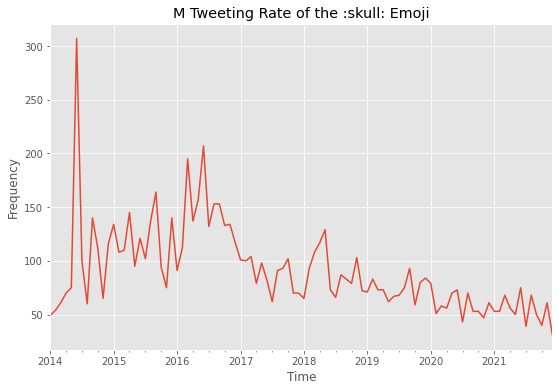

In [359]:
skull_km.plot_tweet_rate()

In [360]:
skull_km.cluster_range((2, 21))

100%|███████████████████████████████████████████| 19/19 [01:32<00:00,  4.87s/it]


In [361]:
skull_km.labels_freq_prop(2)

,count,proportion
0,4269,0.489115
1,4459,0.510885


In [362]:
skull_km.labels_freq_prop(5)

,count,proportion
0,1783,0.204285
1,2357,0.270050
2,1442,0.165215
3,1764,0.202108
4,1382,0.158341


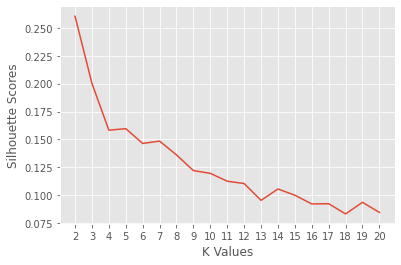

In [363]:
skull_km.plot_silhouette_scores()

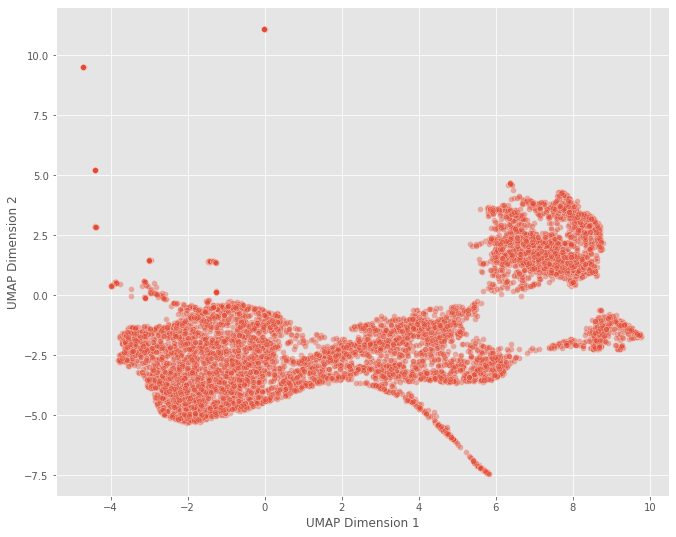

In [364]:
skull_km.plot_umap()

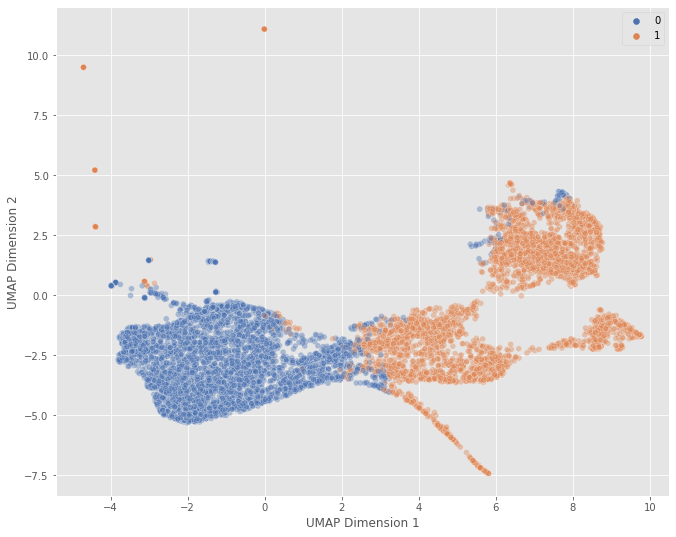

In [365]:
skull_km.plot_umap(2)

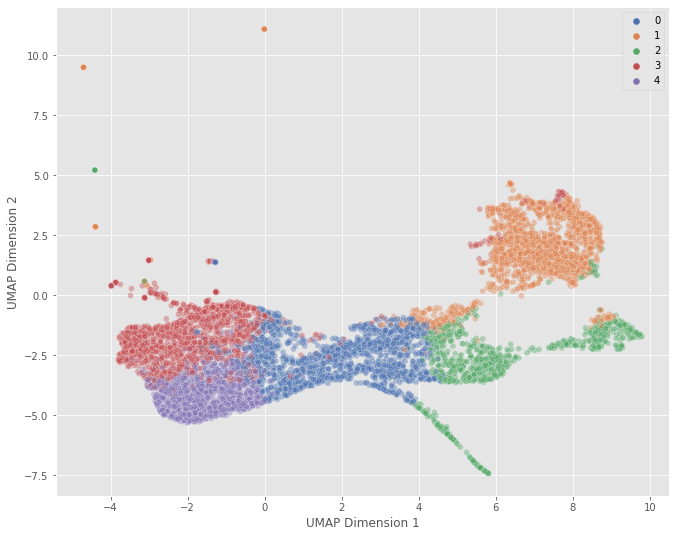

In [366]:
skull_km.plot_umap(5)

In [367]:
skull_km.topic_scores(2)

,cluster_0_scores,cluster_1_scores,absolute_difference
sports,0.069490,0.071477,0.001988
arts_&_culture,0.050247,0.046643,0.003605
gaming,0.009973,0.014096,0.004123
science_&_technology,0.007536,0.011660,0.004123
fitness_&_health,0.006390,0.014961,0.008570
business_&_entrepreneurs,0.018257,0.027168,0.008911
travel_&_adventure,0.010749,0.023613,0.012864
celebrity_&_pop_culture,0.175676,0.161925,0.013750
learning_&_educational,0.013240,0.028127,0.014887
music,0.081402,0.096436,0.015035


In [368]:
skull_km.topic_scores(5)

,cluster_0_scores,cluster_1_scores,cluster_2_scores,cluster_3_scores,cluster_4_scores,standard_dev
science_&_technology,0.006864,0.012671,0.006169,0.010401,0.006443,0.002888
gaming,0.008835,0.015706,0.006394,0.010948,0.009900,0.003435
fitness_&_health,0.006266,0.016930,0.009568,0.005783,0.006224,0.004710
business_&_entrepreneurs,0.020080,0.028280,0.026041,0.021913,0.016017,0.004852
travel_&_adventure,0.011397,0.026349,0.012526,0.012802,0.009433,0.006754
sports,0.060192,0.075700,0.064946,0.058923,0.078382,0.008931
arts_&_culture,0.044407,0.047946,0.040745,0.063885,0.045788,0.008961
learning_&_educational,0.019200,0.031220,0.031371,0.015796,0.010183,0.009458
youth_&_student_life,0.014377,0.028395,0.029790,0.012135,0.005586,0.010591
fashion_&_style,0.024130,0.049783,0.036707,0.024583,0.023873,0.011415


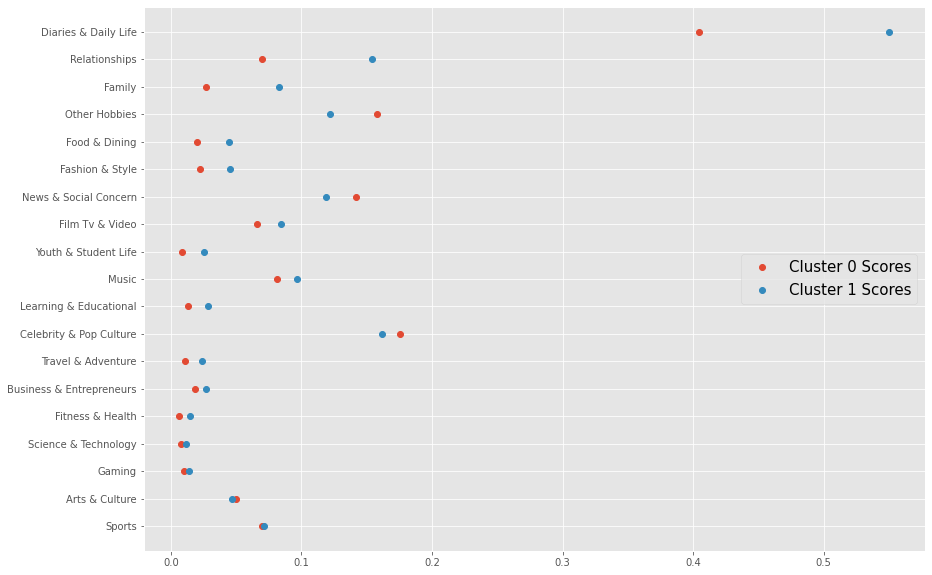

In [369]:
skull_km.plot_clf_scores(2)

In [370]:
skull_km.emotion_sentiment_scores(2)

,cluster_0_scores,cluster_1_scores,absolute_difference
Emotion_anger,0.033039,0.033957,0.000918
Emotion_fear,0.007187,0.009988,0.002801
Emotion_surprise,0.032770,0.049029,0.016260
Emotion_others,0.636406,0.652899,0.016492
Sentiment_NEU,0.256976,0.275537,0.018561
Emotion_sadness,0.113600,0.066963,0.046636
Emotion_joy,0.132769,0.071386,0.061383
Emotion_disgust,0.044229,0.115777,0.071548
Sentiment_NEG,0.213854,0.302281,0.088426
Sentiment_POS,0.529169,0.422182,0.106987


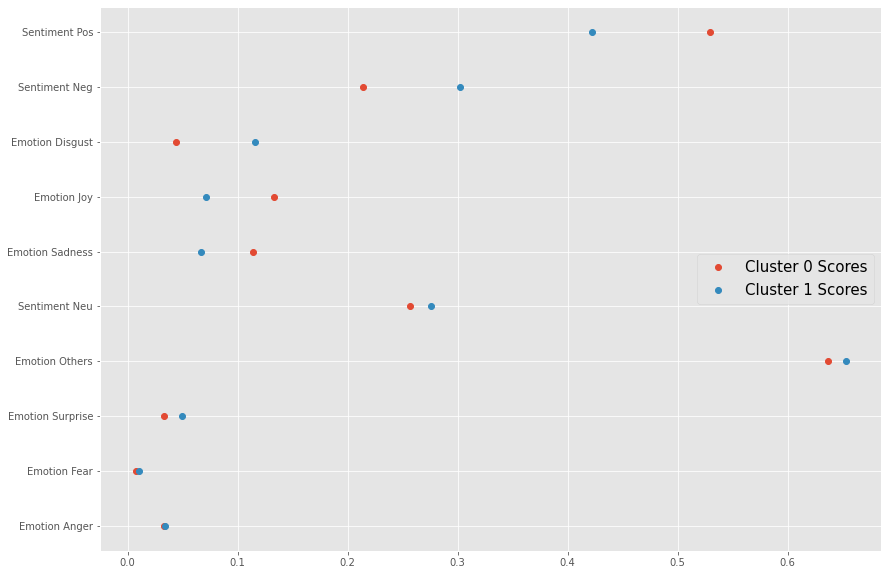

In [371]:
skull_km.plot_clf_scores(2, topics=False)

In [372]:
skull_km.show_centriod_tweets(3, n=5)

Cluster_0:

| "Xbutfuturehusband" 😂😂💀💀 https://t.co/8WkUG9YqsY |
| *bald baby back bitch* 😂😂😂😂💀💀 https://t.co/xFfmadSHr4 |
| DEAD AF 😂😂💀 https://t.co/76yWqXgZQl |
| Not “go brady” 😭😭😭😭💀💀 https://t.co/Z4u3tfp6fa |
| This meat 😂😂😂💀💀 |


Cluster_1:

| @betty_martin8 last I was in a car with you you didn't even know how to go forward 😂😂💀 |
| Mom brought her two stoned daughters to a family dinner &amp; I be damned if ma ain't high off xans 😂💀 |
| @kieramiles04 ok but if the chocolate taste bad probably cause I got a discount on it 😂💀 |
| I remember me, tati &amp; chansy walked in on Chansy’s room mate fucking😂💀 https://t.co/EEEHSrO48C |
| Tell me why my cousins Shawn and Greg said the exact same shit 😂💀 https://t.co/mNiHcxufzB |


Cluster_2:

| lmao water buffalo said what smells like dank 😂😂😂💀💀 |
| why is this me in my car 💀💀💀💀😭 https://t.co/kFTk8os7CE |
| "You look like a BLEACHED BROWNIE BIG FELLA"😂😂😂💀 https://t.co/nwPcUSL4Gh |
| “bleach that pwussy”...”detergent that pwussy” 😂😂😭💀 https

In [373]:
skull_km.words_ratio(2)

,Cluster 0 Words,Cluster 0 Scores,Cluster 1 Words,Cluster 1 Scores
0,OK_hand,6.174407,talk,5.646681
1,red_heart,5.250435,asked,5.190383
2,smiling_face_with_sunglasses,4.716561,big,4.962235
3,face_blowing_a_kiss,4.075108,mom,4.876679
4,OMG,3.773249,ve,4.791123
5,sparkles,3.498830,ya,4.551567
6,grinning_face_with_sweat,2.546943,saw,4.491678
7,Dead,2.405446,having,4.277789
8,flushed_face,2.169618,If,3.832899
9,unamused_face,2.161042,seen,3.811121


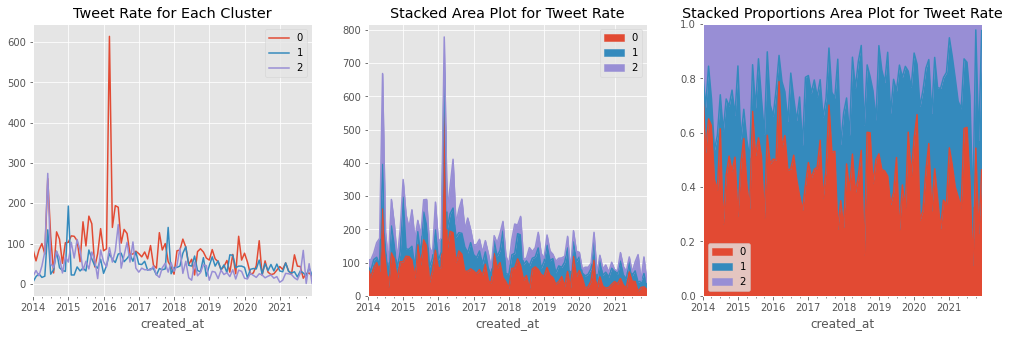

In [374]:
skull_km.visualize_clusters_over_time(3)

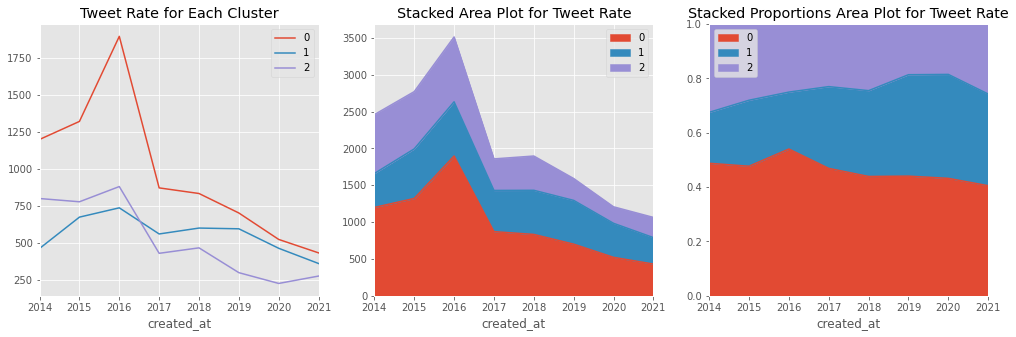

In [375]:
skull_km.visualize_clusters_over_time(3, "Y")

### Model 2:

Emoji: crying 

Model: KMeans

Sampling frac: .1

In [376]:
crying_km = ClusterHub(247, KMeans, sample_frac=.1)

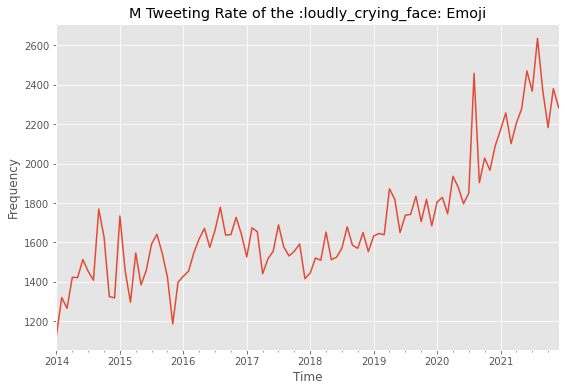

In [377]:
crying_km.plot_tweet_rate()

In [378]:
crying_km.cluster_range((2, 10))

100%|█████████████████████████████████████████████| 8/8 [04:02<00:00, 30.37s/it]


In [379]:
crying_km.labels_freq_prop(2)

,count,proportion
0,95715,0.586223
1,67559,0.413777


In [380]:
crying_km.labels_freq_prop(6)

,count,proportion
0,38617,0.236517
1,26617,0.163020
2,34984,0.214266
3,1106,0.006774
4,37978,0.232603
5,23972,0.146821


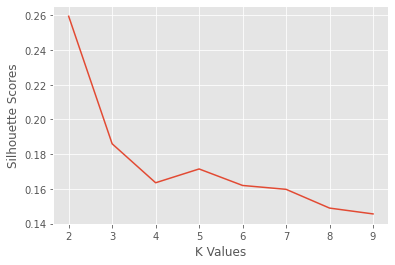

In [381]:
crying_km.plot_silhouette_scores()

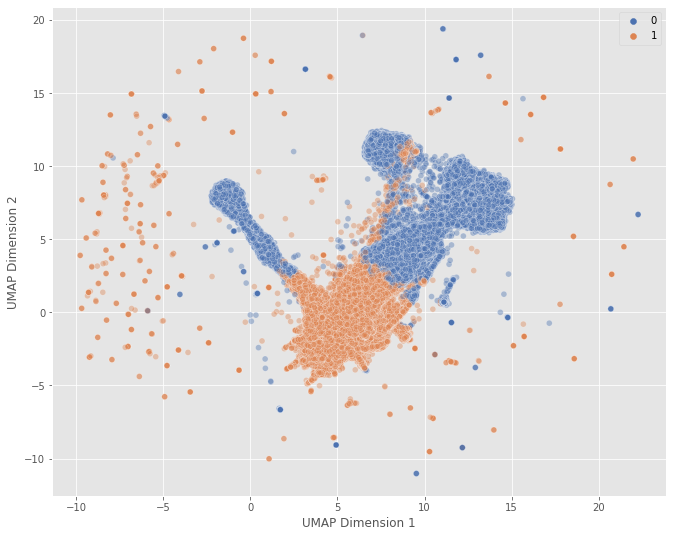

In [382]:
crying_km.plot_umap(2)

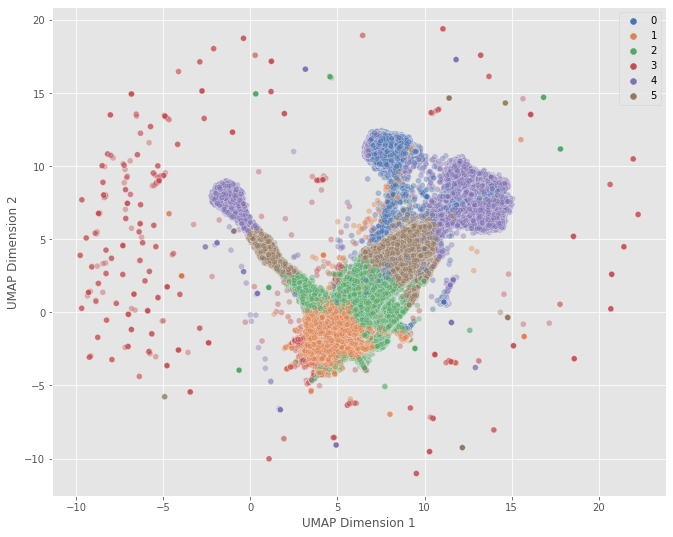

In [383]:
crying_km.plot_umap(6)

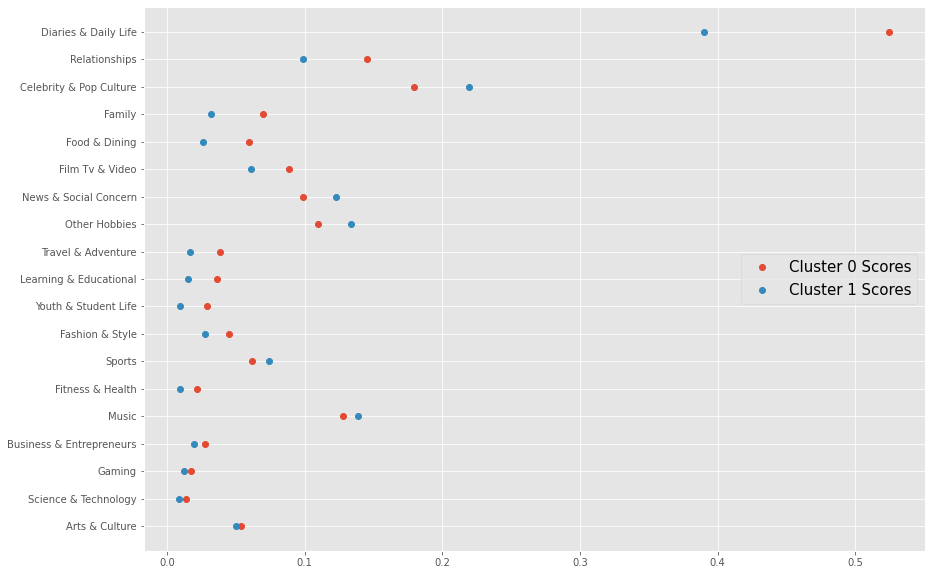

In [384]:
crying_km.plot_clf_scores(2)

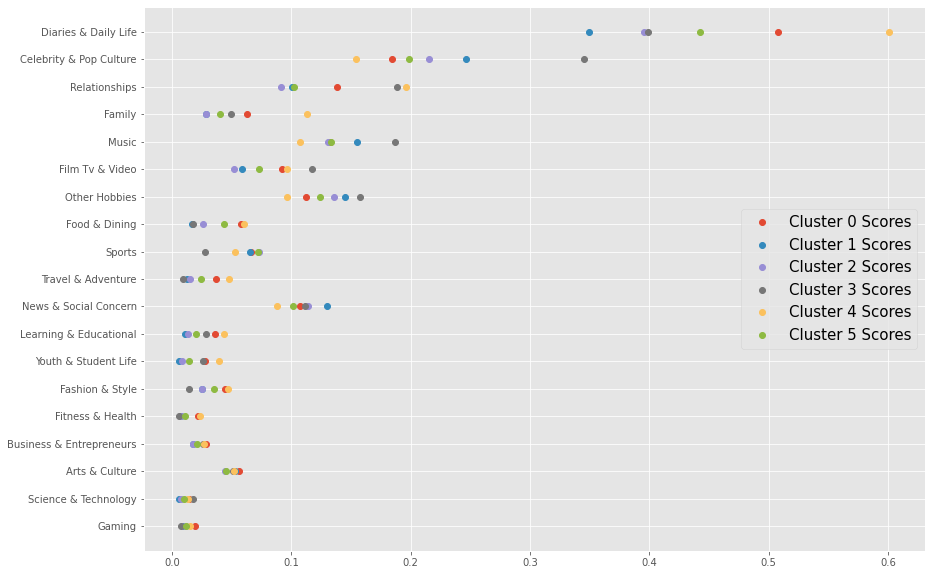

In [385]:
crying_km.plot_clf_scores(6)

In [386]:
crying_km.show_centriod_tweets(4, n=5)

Cluster_0:

| Omg this boul is a dog 😭😭 https://t.co/VtqDSxLKgM |
| @96dhs @yeonjoose My mom said it's a scam 😭😭 |
| @beetington i got this like a week ago bro 😭😭 https://t.co/RmuYXcATvm |
| Composure flew into the  winds 😭😭😭 |
| And Greg is her man 😭😭 https://t.co/Zf1ZWUST9M |


Cluster_1:

| Omg Shes Fire 😍😂😭😭😭 |
| @__GCabrera *cries in Spanish* 😭😭😭💛💛💛 |
| @Stop_Trump20 I can’t BREATHE 😭🤣😭🤣😭🤣😭🤣 these comments😭😭😭😭😭 |
| AMORRRR😭😭😭😭😭😭 https://t.co/e6FaDShCmK |


Cluster_2:

| @LimitlessLotos My sister-in-law and my niece got it for me😭😭 |
| Me attempting to be one of those sexy ass beauty boys with facial hair 😭😭 https://t.co/LMnJm0XzC0 |
| @KirstenJoanna It's really sad cause it's a true story😭😭 |
| If I was to actually save the flics of my nails I would own this shit 😭😭 https://t.co/cOcDNqnZ0L |
| @DuhItzMiaaaa The more I think about it....they might be a serial killer 😭😭 |


Cluster_3:

| @werkkitmya @__youhateash you are crazy😭😭 |
| @Ritacroft_ You're so foolish 😭😭😩 |
| @galsen93 Le

In [387]:
crying_km.words_ratio(4)

,Cluster 0 Words,Cluster 0 Scores,Cluster 1 Words,Cluster 1 Scores,Cluster 2 Words,Cluster 2 Scores,Cluster 3 Words,Cluster 3 Scores
0,miss,2.235884,sparkling_heart,3.356827,bc,3.301445,Thank,2.490058
1,female_sign,2.153629,face_blowing_a_kiss,2.933218,home,2.903023,thank,2.096186
2,person_facepalming,2.013232,light_skin_tone,2.894424,hair,2.897688,USER,1.828323
3,weary_face,1.979276,blue_heart,2.698266,having,2.763939,HTTPURL,1.816268
4,funny,1.723899,growing_heart,2.456661,week,2.748492,Oh,1.679856
5,broken_heart,1.703281,smiling_face_with_heart,2.309073,day,2.721880,Omg,1.664681
6,tired_face,1.534604,eyes,2.227343,school,2.626525,miss,1.565740
7,pensive_face,1.521266,raising_hands,2.089064,year,2.607388,growing_heart,1.519244
8,skull,1.511870,medium,2.085896,mom,2.567930,cute,1.485776
9,medium_skin_tone,1.494237,purple_heart,2.085766,cause,2.513791,omg,1.472781


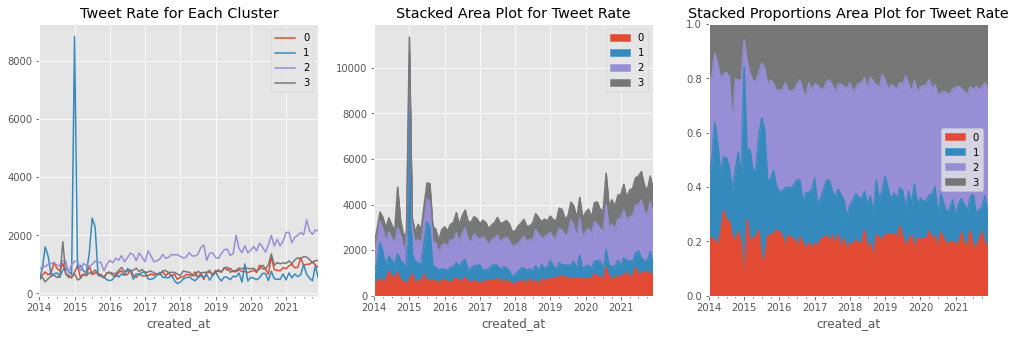

In [388]:
crying_km.visualize_clusters_over_time(4)

## Model 3

Emoji: fire

Model: Agglomerative clustering

Sample frac: None

In [389]:
fire_agg = ClusterHub(1382, AgglomerativeClustering, {"metric":"cosine", "linkage":"complete"})

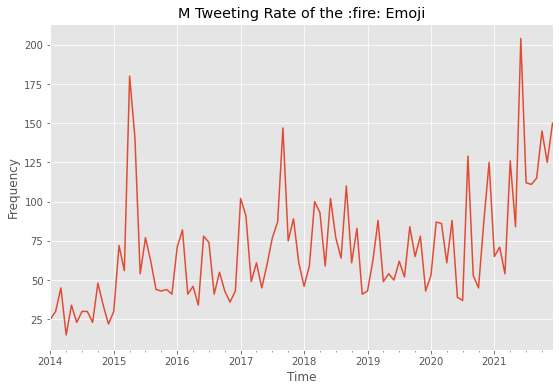

In [390]:
fire_agg.plot_tweet_rate()

In [391]:
fire_agg.cluster_range((2, 30))

100%|███████████████████████████████████████████| 28/28 [10:18<00:00, 22.10s/it]


In [392]:
fire_agg.labels_freq_prop(2)

,count,proportion
0,4778,0.716557
1,1890,0.283443


In [393]:
fire_agg.labels_freq_prop(5)

,count,proportion
0,1195,0.179214
1,1517,0.227504
2,1442,0.216257
3,695,0.104229
4,1819,0.272795


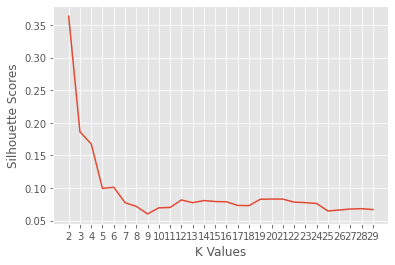

In [394]:
fire_agg.plot_silhouette_scores()

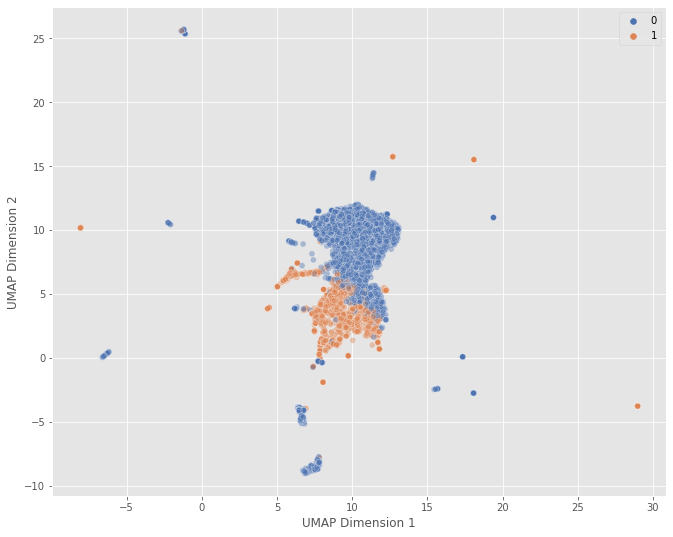

In [395]:
fire_agg.plot_umap(2)

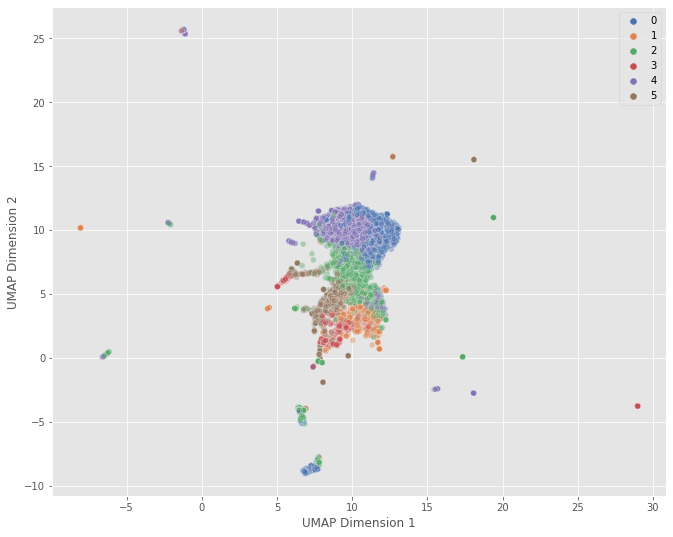

In [396]:
fire_agg.plot_umap(6)

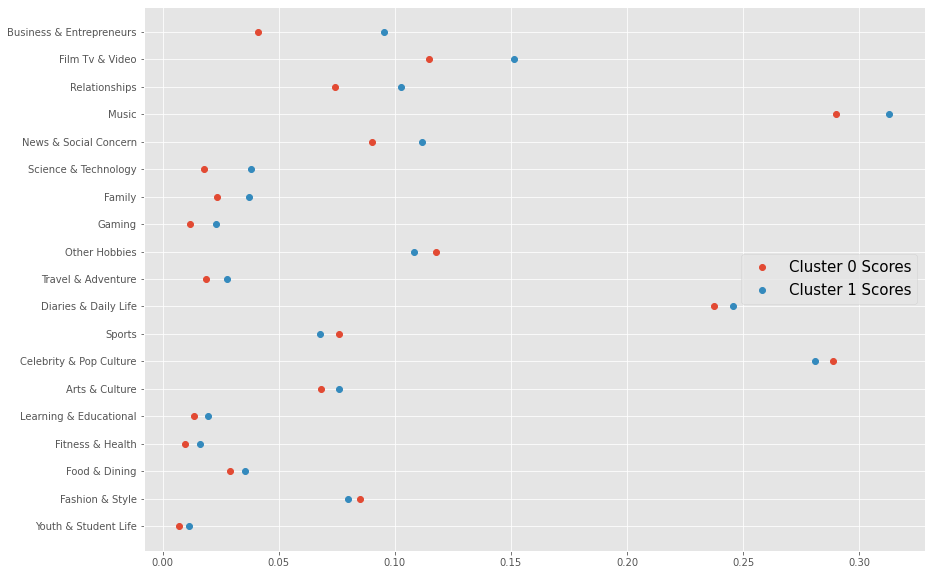

In [397]:
fire_agg.plot_clf_scores(2)

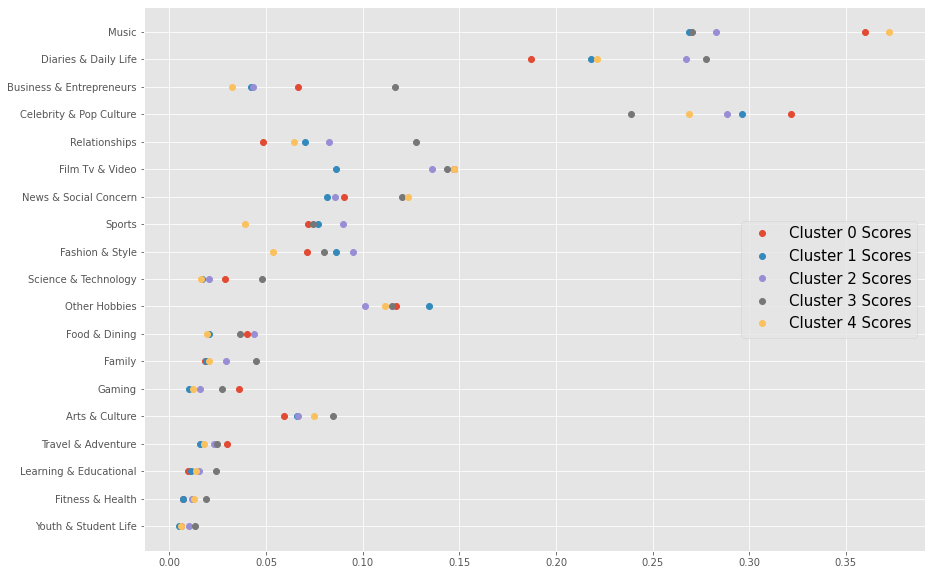

In [398]:
fire_agg.plot_clf_scores(5)

In [399]:
fire_agg.words_ratio(2)

,Cluster 0 Words,Cluster 0 Scores,Cluster 1 Words,Cluster 1 Scores
0,balloon,69.605591,Jack,355.350346
1,soul,65.255242,16th,177.675173
2,fairy,61.992479,6flags,177.675173
3,cityscape,60.904892,DESEVES,177.675173
4,dynamite,60.904892,rewards,138.808729
5,firecracker,60.904892,PLS,120.300898
6,funk,59.817305,SHE,61.075841
7,pinching_hand,59.817305,HER,44.418793
8,shining,59.817305,check_mark_button,34.424565
9,woah,41.328320,hear,14.277469


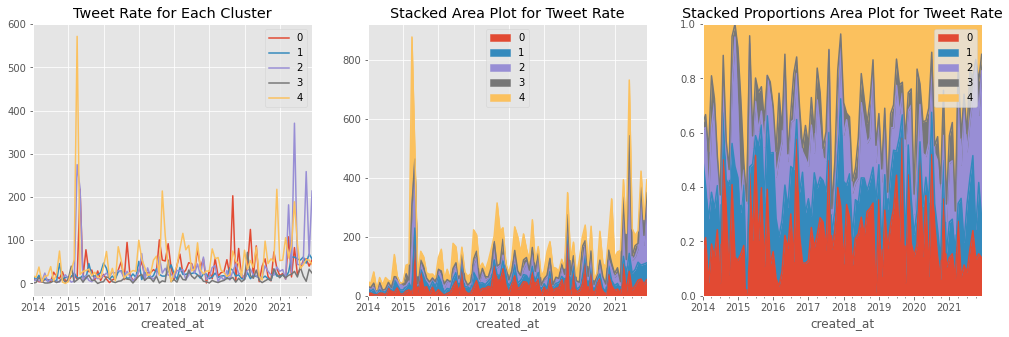

In [400]:
fire_agg.visualize_clusters_over_time(5)